### CORA

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [42]:
# Let's first import all the things we are gonna need for this task

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
# torch_geometric only used to load the Cora dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch_geometric.utils as U

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = Planetoid("/tmp/Cora", name="Cora")
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
num_features = dataset.num_node_features
num_classes = dataset.num_classes

In [43]:
# The Cora dataset contains a single graph of 2708 nodes (i.e., papers).
# We will use some of the nodes as training set and some as test set.
data = dataset[0].to(device)

# According to the GNN equations, we need the adjacency matrix to compute each
# layer convolution. The following line convert the sparse data
# (i.e., list of edges) stored in the dataset in a single dense matrix.
adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)

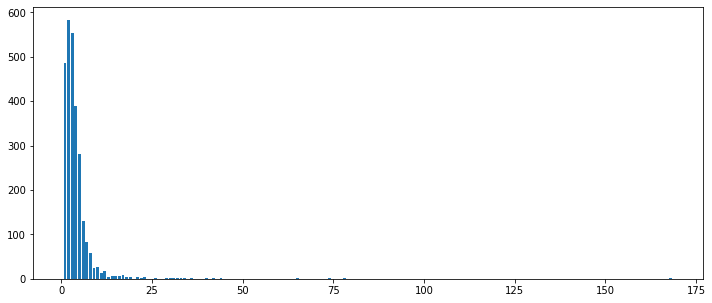

<Figure size 432x288 with 0 Axes>

In [49]:
fig = plt.figure(figsize=(12,5))
x_axis, y_axis = adj_matrix.int().sum(axis=0).unique(return_counts=True)
plt.bar(x_axis, y_axis)
plt.show()
plt.savefig('cora_select.svg')

In [6]:
(adj_matrix.T == adj_matrix).min()

tensor(True)

In [7]:
adj_matrix[0].sum() > 2

tensor(True)

Below we select for training the nodes with degrees at most 4, and for testing the nodes with degrees at least 7, to force a distributional shift.

In [8]:
test_mask = []
for i in range(len(adj_matrix)):
  if adj_matrix[i].sum() >= 7:
    test_mask.append(True)
  else:
    test_mask.append(False)

val_mask = []
for i in range(len(adj_matrix)):
  if adj_matrix[i].sum() >= 5 and adj_matrix[i].sum() <= 6:
    val_mask.append(True)
  else:
    val_mask.append(False)

train_mask = []
for i in range(len(adj_matrix)):
  if adj_matrix[i].sum() <= 4:
    train_mask.append(True)
  else:
    train_mask.append(False)

### MUTAG

In [9]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [11]:
stats = []
for graph_idx in range(len(dataset)):

  data = dataset[graph_idx]  # Get the first graph object.
  adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)
  std = 0
  for i in range(len(adj_matrix)):
    std += (adj_matrix[i].sum() - 2 * data.num_edges / data.num_nodes) ** 2
  std /= len(adj_matrix)
  std = np.sqrt(std)

  stats.append([data.num_nodes, 
                data.num_edges,
                2 * data.num_edges / data.num_nodes,
                std,
                data.has_isolated_nodes(),
                data.has_self_loops(),
                data.is_undirected()])
stats_df = pd.DataFrame(np.array(stats),
                        columns=['no_nodes', 
                                 'no_edges',
                                 'avg_node_degree',
                                 'std_node_degree',
                                 'has_isolated_nodes',
                                 'has_self_loops',
                                 'is_undirected'])

In [12]:
stats_df

,no_nodes,no_edges,avg_node_degree,std_node_degree,has_isolated_nodes,has_self_loops,is_undirected
0,17.0,38.0,4.470588,2.326320,0.0,0.0,1.0
1,13.0,28.0,4.307692,2.253203,0.0,0.0,1.0
2,13.0,28.0,4.307692,2.253203,0.0,0.0,1.0
3,19.0,44.0,4.631579,2.406132,0.0,0.0,1.0
4,11.0,22.0,4.000000,2.174229,0.0,0.0,1.0
...,...,...,...,...,...,...,...
183,22.0,50.0,4.545455,2.393172,0.0,0.0,1.0
184,13.0,26.0,4.000000,2.183857,0.0,0.0,1.0
185,12.0,26.0,4.333333,2.273031,0.0,0.0,1.0
186,21.0,48.0,4.571429,2.370453,0.0,0.0,1.0


In [13]:
stats_df['has_isolated_nodes'].value_counts()

0.0    188
Name: has_isolated_nodes, dtype: int64

In [14]:
stats_df['has_self_loops'].value_counts()

0.0    188
Name: has_self_loops, dtype: int64

In [15]:
stats_df['is_undirected'].value_counts()

1.0    188
Name: is_undirected, dtype: int64

We see that all graphs are undirected, no graphs contain self-loops, and no graphs contain isolated nodes. Hence, only the number of nodes, number of edges, and (average) node degrees will matter in forcing the distributional shift.

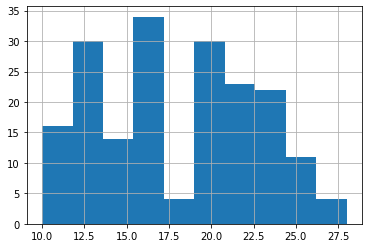

In [16]:
stats_df['no_nodes'].hist()

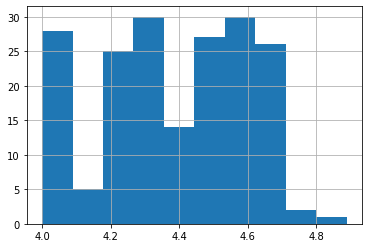

In [17]:
stats_df['avg_node_degree'].hist()

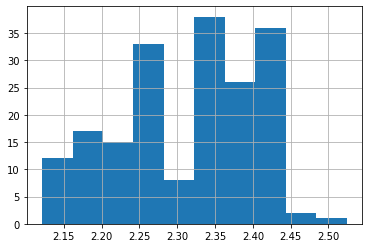

In [18]:
stats_df['std_node_degree'].hist()

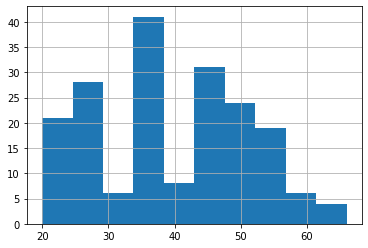

In [19]:
stats_df['no_edges'].hist()

In [20]:
stats_df

,no_nodes,no_edges,avg_node_degree,std_node_degree,has_isolated_nodes,has_self_loops,is_undirected
0,17.0,38.0,4.470588,2.326320,0.0,0.0,1.0
1,13.0,28.0,4.307692,2.253203,0.0,0.0,1.0
2,13.0,28.0,4.307692,2.253203,0.0,0.0,1.0
3,19.0,44.0,4.631579,2.406132,0.0,0.0,1.0
4,11.0,22.0,4.000000,2.174229,0.0,0.0,1.0
...,...,...,...,...,...,...,...
183,22.0,50.0,4.545455,2.393172,0.0,0.0,1.0
184,13.0,26.0,4.000000,2.183857,0.0,0.0,1.0
185,12.0,26.0,4.333333,2.273031,0.0,0.0,1.0
186,21.0,48.0,4.571429,2.370453,0.0,0.0,1.0


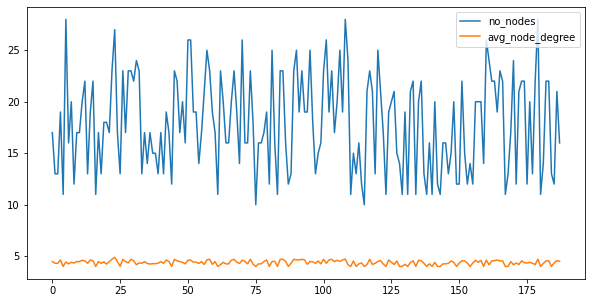

In [21]:
fig = plt.figure(figsize=(10,5))
plt.plot(stats_df['no_nodes'])
plt.plot(stats_df['avg_node_degree'])
plt.legend(['no_nodes', 'avg_node_degree'])
plt.show()

### PROTEINS

In [22]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Extracting data/TUDataset/PROTEINS/PROTEINS.zip
Processing...



Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2


Done!


In [23]:
stats = []
for graph_idx in range(len(dataset)):

  data = dataset[graph_idx]  # Get the first graph object.
  adj_matrix = U.to_dense_adj(data.edge_index).squeeze(0)
  std = 0
  for i in range(len(adj_matrix)):
    std += (adj_matrix[i].sum() - 2 * data.num_edges / data.num_nodes) ** 2
  std /= len(adj_matrix)
  std = np.sqrt(std)

  stats.append([data.num_nodes, 
                data.num_edges,
                2 * data.num_edges / data.num_nodes,
                std,
                data.has_isolated_nodes(),
                data.has_self_loops(),
                data.is_undirected()])
stats_df = pd.DataFrame(np.array(stats),
                        columns=['no_nodes', 
                                 'no_edges',
                                 'avg_node_degree',
                                 'std_node_degree',
                                 'has_isolated_nodes',
                                 'has_self_loops',
                                 'is_undirected'])

In [59]:
!pip install easycolab
import easycolab as ec
ec.mount()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for easycolab: filename=easycolab-0.1b29-py3-none-any.whl size=4471 sha256=9b03ad2e638a3cdefdf2ba0294521d81726e04373b0e26848570ae95bee64bb6
  Stored in directory: /root/.cache/pip/wheels/71/86/f6/5c7d5e887cad8cecdba154f4919c5951fde6d1430e462f18b7
Successfully built easycolab
Mounted at /content/gdrive
Opening directory /content/gdrive/My Drive/
Done!


In [70]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/gdrive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 107] Transport endpoint is not connected: '/content/gdrive/My Drive/'
/content


UsageError: CWD no longer exists - please use %cd to change directory.


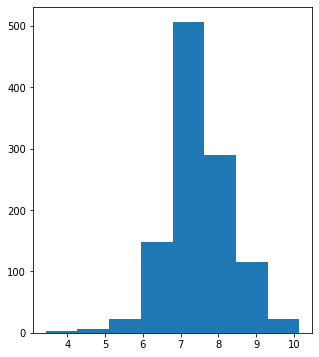

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-fb8f039e1bd7>", line 5, in <module>
    plt.savefig('proteins_select.svg')
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py", line 723, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/figure.py", line 2203, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/backend_bases.py", line 2119, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_svg.py", line 1184, in print_svg
    with cbook.open_file_cm(filename, "w", encoding="utf-8") as fh:
  File "/usr/lib/python3.8/contextlib.py", line 113, in __enter__
    return next(self.gen)
  File "/usr/local/lib/python3.8/dist-

OSError: ignored

<Figure size 432x288 with 0 Axes>

In [74]:
# stats_df['avg_node_degree'].hist()
fig = plt.figure(figsize=(5,6))
plt.hist(stats_df['avg_node_degree'], bins=8);
plt.show()
plt.savefig('proteins_select.svg')

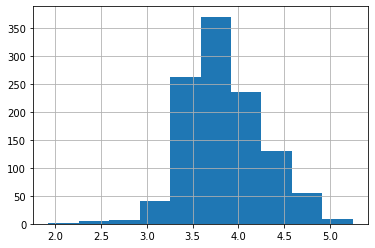

In [25]:
stats_df['std_node_degree'].hist()

In [26]:
threshold = 8
stats_df[stats_df['avg_node_degree'] < threshold]

,no_nodes,no_edges,avg_node_degree,std_node_degree,has_isolated_nodes,has_self_loops,is_undirected
0,42.0,162.0,7.714286,4.029652,0.0,0.0,1.0
1,27.0,92.0,6.814815,3.453394,0.0,0.0,1.0
2,10.0,34.0,6.800000,3.464102,0.0,0.0,1.0
3,24.0,92.0,7.666667,4.041452,0.0,0.0,1.0
4,11.0,42.0,7.636364,3.931227,0.0,0.0,1.0
...,...,...,...,...,...,...,...
1108,5.0,18.0,7.200000,3.633180,0.0,0.0,1.0
1109,15.0,54.0,7.200000,3.669696,0.0,0.0,1.0
1110,16.0,58.0,7.250000,3.674235,0.0,0.0,1.0
1111,5.0,18.0,7.200000,3.633180,0.0,0.0,1.0


In [27]:
train_mask = stats_df[stats_df['avg_node_degree'] < threshold].index.to_list()
test_mask = stats_df[stats_df['avg_node_degree'] >= threshold].index.to_list()

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


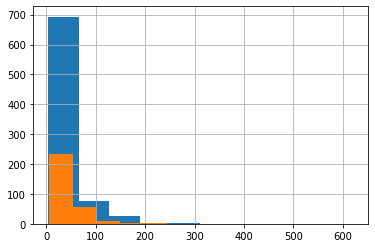

In [28]:
train_df = stats_df.iloc[train_mask]
test_df = stats_df.iloc[test_mask]
print(train_df['no_nodes'].hist())
print(test_df['no_nodes'].hist())

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

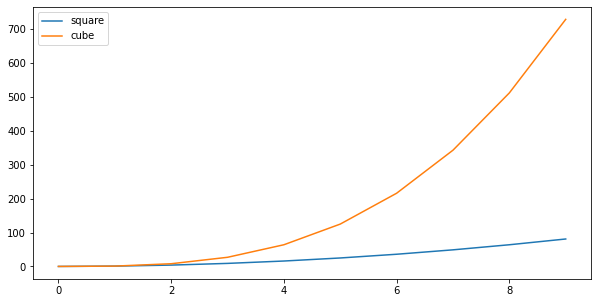

In [30]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(10), np.arange(10) ** 2)
plt.plot(np.arange(10), np.arange(10) ** 3)
plt.legend(['square', 'cube'])
plt.show()